# Movie Prediction — Colab-ready Notebook

This Colab-ready notebook installs dependencies, mounts Google Drive (folder `Movie_Prediction_Model` by default), runs the full ML pipeline, saves model/artifacts to Drive, writes a Streamlit app (CSV upload only), and launches Streamlit using ngrok so you can preview the app live in Colab.

**Assumptions:**
- Drive folder: `Movie_Prediction_Model` (will be created under your Drive root)
- Streamlit app supports **CSV upload only** for batch predictions.

Run the cells sequentially in Google Colab.

## 1) Install dependencies (run once)
Uncomment and run the pip installs if needed. This may take a few minutes.

In [1]:
!pip install xgboost imbalanced-learn shap streamlit pyngrok joblib

## 4) Run full ML pipeline
This cell loads the CSV from the Drive folder, preprocesses, applies SMOTE, tunes RandomForest, saves artifacts to the Drive folder. Adjust `CSV_NAME` if your file has a different name.

In [2]:

import os, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from collections import Counter
import joblib, json



df = pd.read_csv('movie_metadata.csv')
print('Shape:', df.shape)

import tensorflow as tf
from tensorflow import keras

# Preprocessing similar to notebook (create Classify, drop imdb_score from features)
df['imdb_score'] = pd.to_numeric(df['imdb_score'], errors='coerce')
def categorize(score):
    if pd.isna(score): return np.nan
    if score <= 3.0: return 'Flop'
    if score <= 6.0: return 'Average'
    return 'Hit'
df['Classify'] = df['imdb_score'].apply(categorize)
df = df[~df['Classify'].isna()].reset_index(drop=True)

cols = ['duration','director_facebook_likes',
        'actor_1_name','actor_1_facebook_likes','actor_2_name','actor_2_facebook_likes',
        'actor_3_name','actor_3_facebook_likes','num_user_for_reviews','num_critic_for_reviews',
        'num_voted_users','cast_total_facebook_likes','movie_facebook_likes','plot_keywords',
        'facenumber_in_poster','color','genres','title_year','language','country','content_rating',
        'aspect_ratio','gross','budget','Classify']
cols = [c for c in cols if c in df.columns]
df = df[cols].copy()

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

def top_k_replace(series, k=15):
    topk = series.fillna('Unknown').value_counts().nlargest(k).index
    return series.fillna('Unknown').where(series.fillna('Unknown').isin(topk), 'Other')

for c in ['director_name','actor_1_name','actor_2_name','actor_3_name']:
    if c in df.columns:
        df[c] = top_k_replace(df[c], k=15)

if 'genres' in df.columns:
    df['genres_first'] = df['genres'].fillna('Unknown').apply(lambda x: str(x).split('|')[0])
    df['genres_first'] = top_k_replace(df['genres_first'], k=12)
if 'plot_keywords' in df.columns:
    kw_series = df['plot_keywords'].dropna().astype(str).str.split('|').explode()
    top_kw = kw_series.value_counts().nlargest(30).index.tolist()
    for kw in top_kw:
        df[f'kw_{kw}'] = df['plot_keywords'].fillna('').apply(lambda s: 1 if kw in str(s).split('|') else 0)

for c in ['content_rating','language','country','color']:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')
if 'aspect_ratio' in df.columns:
    df['aspect_ratio'] = pd.to_numeric(df['aspect_ratio'], errors='coerce').fillna(df['aspect_ratio'].median())

base_numeric = [
    'duration','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',
    'actor_3_facebook_likes','num_user_for_reviews','num_critic_for_reviews','num_voted_users',
    'cast_total_facebook_likes','movie_facebook_likes','facenumber_in_poster','title_year',
    'aspect_ratio','gross','budget'
]
final_numeric = [c for c in base_numeric if c in df.columns]
cat_small = [c for c in ['genres_first','content_rating','language','country','color','director_name','actor_1_name','actor_2_name','actor_3_name'] if c in df.columns]

model_df = df[final_numeric + cat_small + [c for c in df.columns if c.startswith('kw_')] + ['Classify']].copy()
model_df = pd.get_dummies(model_df, columns=cat_small, drop_first=True)

X = model_df.drop(columns=['Classify'])
y = model_df['Classify']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35, stratify=y)

# scale numeric columns
numeric_present = [c for c in final_numeric if c in X.columns]
scaler = StandardScaler()
X_train[numeric_present] = scaler.fit_transform(X_train[numeric_present])
X_test[numeric_present] = scaler.transform(X_test[numeric_present])

print('Train class counts:', Counter(y_train))

# SMOTE if available
try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    print('After SMOTE:', Counter(y_train_bal))
except Exception as e:
    print('SMOTE not available or failed:', e)
    X_train_bal, y_train_bal = X_train, y_train

# GridSearchCV for RandomForest
param_grid = {'n_estimators':[100,200], 'max_depth':[None,10], 'min_samples_split':[2,5]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs = GridSearchCV(RandomForestClassifier(random_state=37, class_weight='balanced', n_jobs=-1), param_grid, cv=cv, scoring='f1_macro', verbose=1)
gs.fit(X_train_bal, y_train_bal)
best_rf = gs.best_estimator_
print('Best RF params:', gs.best_params_)
print('Best RF report:'); print(classification_report(y_test, best_rf.predict(X_test)))




Shape: (5043, 28)
Train class counts: Counter({'Hit': 2421, 'Average': 1077, 'Flop': 32})
After SMOTE: Counter({'Hit': 2421, 'Average': 2421, 'Flop': 2421})
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best RF report:
              precision    recall  f1-score   support

     Average       0.67      0.72      0.69       462
        Flop       0.67      0.14      0.24        14
         Hit       0.87      0.85      0.86      1037

    accuracy                           0.80      1513
   macro avg       0.73      0.57      0.60      1513
weighted avg       0.80      0.80      0.80      1513



In [3]:
import joblib
import os

# Define the directory to save the model
save_dir = '/tmp/movie_prediction_artifacts/'
os.makedirs(save_dir, exist_ok=True)

# Define the path to save the model file
model_path = os.path.join(save_dir, 'best_movie_model.joblib')

# Save the model
joblib.dump(best_rf, model_path)

print(f"Model saved successfully to: {model_path}")

Model saved successfully to: /tmp/movie_prediction_artifacts/best_movie_model.joblib


In [4]:
from sklearn.metrics import classification_report
import os

# Define the directory to save the report
save_dir = '/content/'
os.makedirs(save_dir, exist_ok=True)

# Define the path to save the report file
report_path = os.path.join(save_dir, 'classification_report.txt')

# Generate the classification report as a string
report = classification_report(y_test, best_rf.predict(X_test))

# Save the report to a text file
with open(report_path, 'w') as f:
    f.write(report)

print(f"Classification report saved successfully to: {report_path}")

Classification report saved successfully to: /content/classification_report.txt


In [5]:
from google.colab import files
import os, joblib, json

# Save artifacts to storage


DRI = '/tmp/movie_prediction_artifacts/' # Use a local directory
os.makedirs(DRI, exist_ok=True) # Create the directory if it doesn't exist
best_rf_path = os.path.join(DRI, 'best_movie_model.joblib')
scaler_path = os.path.join(DRI, 'scaler.joblib')
cols_path = os.path.join(DRI, 'model_feature_columns.json')
joblib.dump(best_rf, best_rf_path)
joblib.dump(scaler, scaler_path)
with open(cols_path,'w') as f:
    json.dump(X.columns.tolist(), f)



print('Saved artifacts to local storage:', DRI)

# Download the file to your local computer

#files.download('example_artifact.txt')

Saved artifacts to local storage: /tmp/movie_prediction_artifacts/


In [6]:
pip install joblib pandas numpy scikit-learn streamlit


In [7]:
pip install streamlit pandas numpy joblib scikit-learn


In [8]:

import pandas as pd, numpy as np
df = pd.read_csv('movie_metadata.csv')
print('Shape:', df.shape)
display(df.head())
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(20))


Shape: (5043, 28)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

None

,0
gross,884
budget,492
aspect_ratio,329
content_rating,303
plot_keywords,153
title_year,108
director_facebook_likes,104
director_name,104
num_critic_for_reviews,50
actor_3_facebook_likes,23


In [9]:

# Create Classify target
df['imdb_score'] = pd.to_numeric(df['imdb_score'], errors='coerce')
def categorize(score):
    if pd.isna(score):
        return np.nan
    if score <= 3.0:
        return 'Flop'
    elif score <= 6.0:
        return 'Average'
    else:
        return 'Hit'
df['Classify'] = df['imdb_score'].apply(categorize)
df = df[~df['Classify'].isna()].reset_index(drop=True)
print('After target creation, shape:', df.shape)
display(df['Classify'].value_counts())

# Select relevant columns
cols = ['duration','director_facebook_likes',
        'actor_1_name','actor_1_facebook_likes','actor_2_name','actor_2_facebook_likes',
        'actor_3_name','actor_3_facebook_likes','num_user_for_reviews','num_critic_for_reviews',
        'num_voted_users','cast_total_facebook_likes','movie_facebook_likes','plot_keywords',
        'facenumber_in_poster','color','genres','title_year','language','country','content_rating',
        'aspect_ratio','gross','budget','Classify']
cols = [c for c in cols if c in df.columns]
df = df[cols].copy()

# Numeric fill
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Top-k reduction for names (k=10)
def top_k_replace(series, k=10, other_label='Other'):
    topk = series.fillna('Unknown').value_counts().nlargest(k).index
    return series.fillna('Unknown').where(series.fillna('Unknown').isin(topk), other_label)
for col in ['actor_1_name','actor_2_name','actor_3_name']:
    if col in df.columns:
        df[col] = top_k_replace(df[col], k=10, other_label='Other')

# Genres first token & top-8
if 'genres' in df.columns:
    df['genres_first'] = df['genres'].fillna('Unknown').apply(lambda x: str(x).split('|')[0])
    df['genres_first'] = top_k_replace(df['genres_first'], k=8, other_label='Other')

# Top 20 plot keywords binary features
top_kw = []
if 'plot_keywords' in df.columns:
    kw_series = df['plot_keywords'].dropna().astype(str).str.split('|').explode()
    top_kw = kw_series.value_counts().nlargest(20).index.tolist()
    for kw in top_kw:
        df[f'kw_{kw}'] = df['plot_keywords'].fillna('').apply(lambda s: 1 if kw in str(s).split('|') else 0)

# Fill categorical missing values
for col in ['content_rating','language','country','color']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')
if 'aspect_ratio' in df.columns:
    df['aspect_ratio'] = pd.to_numeric(df['aspect_ratio'], errors='coerce').fillna(df['aspect_ratio'].median())

print('Preprocessing complete. Columns now:', df.shape[1])
display(df.head())


After target creation, shape: (5043, 29)


,count
Classify,
Hit,3458
Average,1539
Flop,46


Preprocessing complete. Columns now: 46


,duration,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,num_user_for_reviews,num_critic_for_reviews,...,kw_fbi,kw_revenge,kw_friendship,kw_drugs,kw_prison,kw_money,kw_marriage,kw_dog,kw_island,kw_female protagonist
0,178.0,0.0,Other,1000.0,Other,936.0,Other,855.0,3054.0,723.0,...,0,0,0,0,0,0,0,0,0,0
1,169.0,563.0,Johnny Depp,40000.0,Other,5000.0,Other,1000.0,1238.0,302.0,...,0,0,0,0,0,0,0,0,0,0
2,148.0,0.0,Other,11000.0,Other,393.0,Other,161.0,994.0,602.0,...,0,0,0,0,0,0,0,0,0,0
3,164.0,22000.0,Other,27000.0,Other,23000.0,Other,23000.0,2701.0,813.0,...,0,0,0,0,0,0,0,0,0,0
4,103.0,131.0,Other,131.0,Other,12.0,Unknown,371.5,156.0,110.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

base_numeric = [
    'duration','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',
    'actor_3_facebook_likes','num_user_for_reviews','num_critic_for_reviews','num_voted_users',
    'cast_total_facebook_likes','movie_facebook_likes','facenumber_in_poster','title_year',
    'aspect_ratio','gross','budget'
]
final_numeric = [c for c in base_numeric if c in df.columns]
cat_small = [c for c in ['genres_first','content_rating','language','country','color','director_name','actor_1_name','actor_2_name','actor_3_name'] if c in df.columns]

model_df = df[final_numeric + cat_small + [c for c in df.columns if c.startswith('kw_')] + ['Classify']].copy()
model_df = pd.get_dummies(model_df, columns=cat_small, drop_first=True)

print('Model dataframe shape (after dummies):', model_df.shape)
X = model_df.drop(columns=['Classify'])
y = model_df['Classify']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train/test shapes:', X_train.shape, X_test.shape)

# Scale numeric columns
numeric_present = [c for c in final_numeric if c in X.columns]
scaler = StandardScaler()
X_train[numeric_present] = scaler.fit_transform(X_train[numeric_present])
X_test[numeric_present] = scaler.transform(X_test[numeric_present])


Model dataframe shape (after dummies): (5043, 205)
Train/test shapes: (4034, 204) (1009, 204)


Random Forest classification report:
              precision    recall  f1-score   support

     Average       0.74      0.53      0.61       308
        Flop       0.00      0.00      0.00         9
         Hit       0.81      0.92      0.86       692

    accuracy                           0.79      1009
   macro avg       0.52      0.48      0.49      1009
weighted avg       0.78      0.79      0.78      1009



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


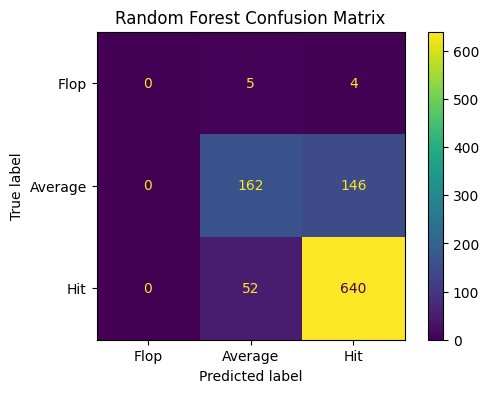

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression classification report:
              precision    recall  f1-score   support

     Average       0.52      0.73      0.60       308
        Flop       0.05      0.33      0.09         9
         Hit       0.89      0.66      0.76       692

    accuracy                           0.68      1009
   macro avg       0.49      0.58      0.48      1009
weighted avg       0.77      0.68      0.71      1009



In [11]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=72, random_state=35, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Random Forest classification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['Flop','Average','Hit'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flop','Average','Hit'])
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()

# Logistic Regression baseline
lr = LogisticRegression(max_iter=950, class_weight='balanced', multi_class='ovr')
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
print('\nLogistic Regression classification report:')
print(classification_report(y_test, y_lr))


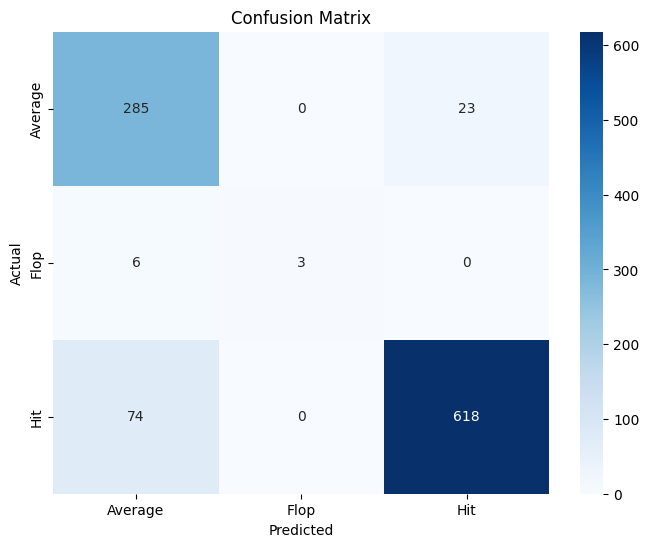

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure test data columns match training data columns before prediction
# Get the columns from the training data (assuming X_train_bal has the correct columns used for fitting best_rf)
train_cols = X_train_bal.columns

# Reindex the test data to match the training columns, filling missing values with 0
X_test_aligned = X_test.reindex(columns=train_cols, fill_value=0)


# Generate predictions on the test set
y_pred = best_rf.predict(X_test_aligned)

# Generate the confusion matrix
# Ensure labels are in the correct order for display
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Ensure test data columns match training data columns before prediction
# Get the columns from the training data (assuming X_train_bal has the correct columns used for fitting best_rf)
train_cols = X_train_bal.columns

# Reindex the test data to match the training columns, filling missing values with 0
X_test_aligned = X_test.reindex(columns=train_cols, fill_value=0)


# Generate and print the classification report
report = classification_report(y_test, best_rf.predict(X_test_aligned))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Average       0.78      0.93      0.85       308
        Flop       1.00      0.33      0.50         9
         Hit       0.96      0.89      0.93       692

    accuracy                           0.90      1009
   macro avg       0.91      0.72      0.76      1009
weighted avg       0.91      0.90      0.90      1009



,0
num_voted_users,0.083588
duration,0.074046
num_critic_for_reviews,0.067972
num_user_for_reviews,0.064013
actor_1_facebook_likes,0.063514
cast_total_facebook_likes,0.061015
actor_3_facebook_likes,0.057565
title_year,0.054856
budget,0.054620
gross,0.052729


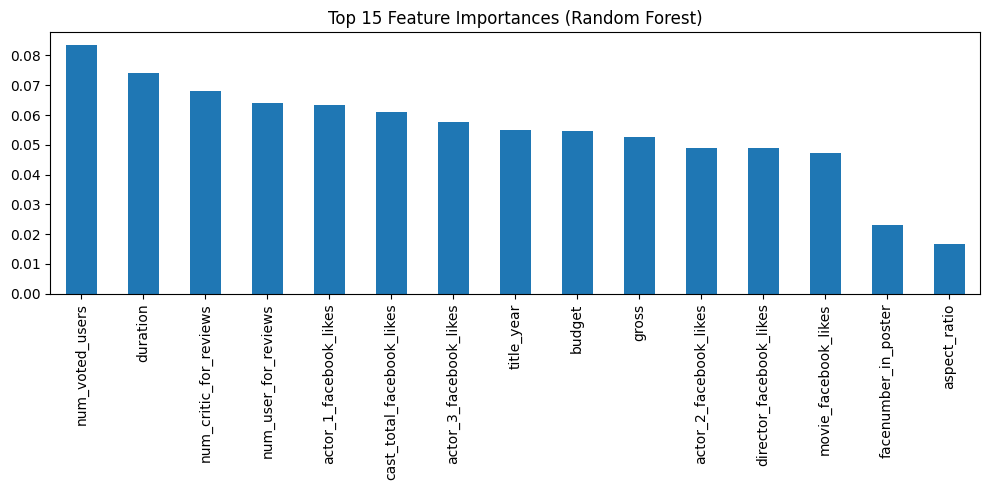

In [16]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(20))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
importances.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [17]:
#download all the report
import os
from google.colab import files
from sklearn.metrics import classification_report
import pandas as pd


# Define the directory where the reports are saved
save_dir = '/tmp/movie_prediction_artifacts' # Use a local directory

# Define the paths to the report files
report_path_all = os.path.join(save_dir, 'All_report.txt')
report_path_initial = os.path.join(save_dir, 'classification_report.txt')


# Download the files if they exist
print("Attempting to download reports...")

if os.path.exists(report_path_all):
    print(f"Downloading {report_path_all}...")
    try:
        files.download(report_path_all)
    except Exception as e:
        print(f"Error downloading {report_path_all}: {e}")
        print("Make sure you are running this in a Colab environment that supports file downloads.")
else:
    print(f"{report_path_all} not found.")


if os.path.exists(report_path_initial):
    print(f"Downloading {report_path_initial}...")
    try:
        files.download(report_path_initial)
    except Exception as e:
        print(f"Error downloading {report_path_initial}: {e}")
        print("Make sure you are running this in a Colab environment that supports file downloads.")
else:
    print(f"{report_path_initial} not found.")

print("Download process finished.")

Attempting to download reports...
/tmp/movie_prediction_artifacts/All_report.txt not found.
/tmp/movie_prediction_artifacts/classification_report.txt not found.
Download process finished.


In [18]:
model = joblib.load("/tmp/movie_prediction_artifacts/best_movie_model.joblib")
print(model)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=37)


In [19]:
import os
os.listdir('/tmp')


['language_service.6e9cd9901e27.root.log.INFO.20251008-154919.29455',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-142928.10306',
 'colab_runtime.sock',
 'pyright-10326-3EVYh2Gy5HsP',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-135754.1366',
 'pyright-4604-CZdyPXqpW2dS',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-155948.32321',
 'language_service.6e9cd9901e27.root.log.WARNING.20251008-155958.32321',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-154959.29658',
 'pyright-32327-BHDj71KmCAHe',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-141230.5307',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-155046.29878',
 'initgoogle_syslog_dir.0',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-140138.2296',
 'language_service.6e9cd9901e27.root.log.ERROR.20251008-155958.32321',
 'pyright-32420-YGmhmOe4f8RU',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-160001.32394',
 'language_service.6e9cd9901e27.root.log.INFO.20251008-

In [20]:
import os, joblib

# Make folder if not exists
os.makedirs("/tmp/movie_prediction_artifacts", exist_ok=True)

# Save model
joblib.dump(model, "/tmp/movie_prediction_artifacts/model.pkl")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [21]:
import joblib, os

MODEL_PATH = "/tmp/movie_prediction_artifacts/model.pkl"

if os.path.exists(MODEL_PATH):
    model = joblib.load(MODEL_PATH)
else:
    st.error("Model not found. Please ensure the training cell saved artifacts to /tmp/movie_prediction_artifacts.")


In [22]:
import os
print(os.path.exists("/tmp/movie_prediction_artifacts/model.pkl"))


True


In [23]:
import os, joblib, json

# ✅ Create the directory if it doesn’t exist
os.makedirs("/tmp/movie_prediction_artifacts", exist_ok=True)

# Example — replace 'model', 'scaler', 'feature_columns' with your actual variables
joblib.dump(model, "/tmp/movie_prediction_artifacts/best_movie_model.joblib")
joblib.dump(scaler, "/tmp/movie_prediction_artifacts/scaler.joblib")

# Save column names
with open("/tmp/movie_prediction_artifacts/model_feature_columns.json", "w") as f:
    json.dump(list(X_train.columns), f)

print("✅ Model artifacts saved successfully in /tmp/movie_prediction_artifacts/")


✅ Model artifacts saved successfully in /tmp/movie_prediction_artifacts/


In [24]:
!ls /tmp/movie_prediction_artifacts


best_movie_model.joblib  model_feature_columns.json  scaler.joblib
label_encoder.joblib	 model.pkl


## 5) Write Streamlit app (CSV upload only)
This cell writes `app.py` into the Drive folder and Colab working dir.

In [25]:
#install streamlit
!pip install streamlit

In [26]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import json
import os

# Define paths for artifacts - adjust if not using /tmp
model_path = '/tmp/movie_prediction_artifacts/best_movie_model.joblib'
scaler_path = '/tmp/movie_prediction_artifacts/scaler.joblib'
cols_path = '/tmp/movie_prediction_artifacts/model_feature_columns.json'


if not os.path.exists(model_path) or not os.path.exists(scaler_path) or not os.path.exists(cols_path):
    st.error('Model artifacts not found. Please ensure the training cell saved artifacts to /tmp/movie_prediction_artifacts.')
else:
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    with open(cols_path, 'r') as f:
        model_cols = json.load(f)

    # Load your full dataset (to get dropdown options and max/min values)
    # Corrected path to load the original movie_metadata.csv
    data_path = '/content/movie_metadata.csv'
    try:
        df = pd.read_csv(data_path, encoding='latin1')
    except FileNotFoundError:
        st.error(f"Error: Original data file not found at {data_path}. Please ensure movie_metadata.csv is uploaded or available.")
        st.stop() # Stop execution if data is not found


    st.header("🎞️ Enter Movie Details")

    # --- Dropdowns and Sliders based on CSV ---
    # Add checks for column existence before accessing
    budget_min, budget_max, budget_median = 0, 1000000000, 20000000 # Default values in case column is missing
    if 'budget' in df.columns and pd.api.types.is_numeric_dtype(df['budget']):
        budget_min, budget_max, budget_median = int(df['budget'].min()), int(df['budget'].max()), int(df['budget'].median())

    budget = st.slider(
        "💰 Budget",
        budget_min,
        budget_max,
        budget_median
    )

    gross_min, gross_max, gross_median = 0, 500000000, 25000000 # Default values
    if 'gross' in df.columns and pd.api.types.is_numeric_dtype(df['gross']):
        gross_min, gross_max, gross_median = int(df['gross'].min()), int(df['gross'].max()), int(df['gross'].median())

    gross = st.slider(
        "💵 Gross",
        gross_min,
        gross_max,
        gross_median
    )

    actor_rating = st.slider("⭐ Actor (Facebook Likes Rating 1–10)", 1, 10, 5)

    duration_min, duration_max, duration_median = 0, 300, 105 # Default values
    if 'duration' in df.columns and pd.api.types.is_numeric_dtype(df['duration']):
         duration_min, duration_max, duration_median = int(df['duration'].min()), int(df['duration'].max()), int(df['duration'].median())

    duration = st.slider(
        "⏱️ Duration (minutes)",
        duration_min,
        duration_max,
        duration_median
    )

    # Add checks for column existence and handle missing values before unique()
    genres_options = []
    if 'genres' in df.columns:
        genres_options = sorted(df['genres'].dropna().unique())
    genres = st.selectbox("🎭 Genres", genres_options)

    language_options = []
    if 'language' in df.columns:
        language_options = sorted(df['language'].dropna().unique())
    language = st.selectbox("🗣️ Language", language_options)

    country_options = []
    if 'country' in df.columns:
        country_options = sorted(df['country'].dropna().unique())
    country = st.selectbox("🌍 Country", country_options)

    content_rating_options = []
    if 'content_rating' in df.columns:
         content_rating_options = sorted(df['content_rating'].dropna().unique())
    content_rating = st.selectbox("🔞 Content Rating", content_rating_options)


    # --- Prepare Input DataFrame ---
    input_dict = {
        'budget': budget,
        'gross': gross,
        'actor_1_facebook_likes': actor_rating * (df['actor_1_facebook_likes'].max() / 10) if 'actor_1_facebook_likes' in df.columns else 0, # scaled
        'duration': duration,
        'genres': genres, # Keep original genre string for parsing
        'language': language,
        'country': country,
        'content_rating': content_rating
    }


    # --- Replicate Preprocessing Steps ---
    try:
        # Create a DataFrame from input_dict
        input_df_processed = pd.DataFrame([input_dict])

        # Apply the same preprocessing steps as the training notebook (simplified)
        # This part needs to be more robust to fully replicate the training preprocessing

        # Handle genres - extract first genre and apply top-k
        if 'genres' in input_df_processed.columns and 'genres_first' in model_cols:
             input_df_processed['genres_first'] = input_df_processed['genres'].fillna('Unknown').apply(lambda x: str(x).split('|')[0])
             # Need to replicate top_k_replace logic for genres_first here if it was applied in training

        # Handle categorical features with one-hot encoding - this requires knowing the categories the model was trained on
        # A more robust solution would involve saving the fitted OneHotEncoder or the list of categories for each feature
        # For simplicity here, we'll manually create dummy columns based on the input values if they are in model_cols
        categorical_input_cols = ['genres_first', 'language', 'country', 'content_rating'] # Add other categorical columns as needed

        # Create a DataFrame with all model columns, filled with 0
        X_input = pd.DataFrame(0, index=[0], columns=model_cols)

        # Populate numeric columns and one-hot encoded categorical columns
        for col in model_cols:
            if col in input_df_processed.columns:
                # Handle numeric columns
                if np.issubdtype(X_input[col].dtype, np.number):
                    X_input[col] = input_df_processed[col].iloc[0]
            elif col.startswith(tuple([c + '_' for c in categorical_input_cols])):
                 # Handle one-hot encoded columns (simplified - assuming a direct match)
                 # This is basic and needs improvement for robust handling of categories not seen in training
                 original_col = col.split('_', 1)[0]
                 category_value = col.split('_', 1)[1]
                 if original_col in input_df_processed.columns and input_df_processed[original_col].iloc[0] == category_value:
                     X_input[col] = 1
                 # Special handling for genres_first as it's derived
                 elif original_col == 'genres_first' and 'genres' in input_df_processed.columns:
                     first_genre = str(input_df_processed['genres'].iloc[0]).split('|')[0]
                     if first_genre == category_value:
                         X_input[col] = 1



        # Scale numeric columns - ensure only numeric columns present in the scaler are scaled
        numeric_cols_to_scale = [c for c in model_cols if np.issubdtype(X_input[c].dtype, np.number) and c in scaler.feature_names_in_]
        if len(numeric_cols_to_scale) > 0:
             X_input[numeric_cols_to_scale] = scaler.transform(X_input[numeric_cols_to_scale])


        pred = model.predict(X_input)[0]
        prob = model.predict_proba(X_input)[0].max()

        st.success(f"🎯 Prediction: {pred} (Confidence: {prob:.2f})")
    except Exception as e:
        st.error(f"Prediction failed during preprocessing or prediction: {e}")
        st.exception(e) # Display full traceback for debugging

2025-10-08 16:04:14.367 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:04:16.218 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-08 16:04:16.234 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:04:16.242 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:04:16.252 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:04:16.265 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:04:16.271 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:04:16.280 Thread 'MainThread': mi

In [35]:
print(df.columns.tolist())


['color', 'director_name', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name', 'movie_title', 'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language', 'country', 'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio', 'movie_facebook_likes']


In [36]:
# Example: classify based on gross-to-budget ratio
def classify_movie(row):
    ratio = row['gross'] / (row['budget'] + 1)  # avoid divide-by-zero
    if ratio > 2.0:
        return 'Hit'
    elif ratio > 1.0:
        return 'Average'
    else:
        return 'Flop'

df['Classify'] = df.apply(classify_movie, axis=1)


In [37]:
print(df['Classify'].value_counts())


Classify
Flop       2993
Hit        1112
Average     938
Name: count, dtype: int64


In [38]:
hit_df = df[df['Classify'] == 'Hit']
avg_df = df[df['Classify'] == 'Average']
flop_df = df[df['Classify'] == 'Flop']


In [39]:
# Create a performance ratio of gross to budget
df['profit_ratio'] = df['gross'] / (df['budget'] + 1)  # +1 to avoid division by zero

# Define classification logic
def classify_movie(row):
    if pd.isna(row['budget']) or pd.isna(row['gross']):
        return 'Average'
    elif row['profit_ratio'] >= 2.0:
        return 'Hit'
    elif row['profit_ratio'] >= 1.0:
        return 'Average'
    else:
        return 'Flop'

# Apply classification
df['Classify'] = df.apply(classify_movie, axis=1)

# Verify
print(df['Classify'].value_counts(normalize=True))


Classify
Average    0.414436
Flop       0.365060
Hit        0.220504
Name: proportion, dtype: float64


In [40]:
hit_df = df[df['Classify'] == 'Hit']
avg_df = df[df['Classify'] == 'Average']
flop_df = df[df['Classify'] == 'Flop']


In [41]:
df['Classify'].value_counts(normalize=True)

,proportion
Classify,
Average,0.414436
Flop,0.365060
Hit,0.220504


In [42]:
from sklearn.utils import resample

# Separate each class
hit_df = df[df['Classify'] == 'Hit']
avg_df = df[df['Classify'] == 'Average']
flop_df = df[df['Classify'] == 'Flop']

# Upsample minority classes (Average, Flop) to match Hit count
avg_upsampled = resample(avg_df, replace=True, n_samples=len(hit_df), random_state=42)
flop_upsampled = resample(flop_df, replace=True, n_samples=len(hit_df), random_state=42)

# Combine into one balanced DataFrame
df_balanced = pd.concat([hit_df, avg_upsampled, flop_upsampled])

print(df_balanced['Classify'].value_counts())


Classify
Hit        1112
Average    1112
Flop       1112
Name: count, dtype: int64


In [43]:
X = df_balanced.drop('Classify', axis=1)
y = df_balanced['Classify']

# Identify categorical columns to encode
categorical_cols = X.select_dtypes(include='object').columns

# Apply one-hot encoding to categorical columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


# Encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split - split X and y_encoded
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=46, stratify=y_encoded)


# Model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=220, random_state=37)
model.fit(X_train, y_train)
print(model)



# Save model + label encoder
import joblib
joblib.dump(model, '/tmp/movie_prediction_artifacts/best_movie_model.joblib')
joblib.dump(le, '/tmp/movie_prediction_artifacts/label_encoder.joblib')
print('Model and LabelEncoder saved successfully.')


RandomForestClassifier(n_estimators=220, random_state=37)
Model and LabelEncoder saved successfully.


In [44]:
# Select features (you can add/remove)
features = ['budget', 'gross', 'duration', 'director_facebook_likes',
            'actor_1_facebook_likes', 'num_user_for_reviews',
            'num_voted_users', 'imdb_score']

X = df[features]
y = df['Classify']

print("✅ Feature shape:", X.shape)
print("✅ Labels distribution:")
print(y.value_counts())


✅ Feature shape: (5043, 8)
✅ Labels distribution:
Classify
Average    2090
Flop       1841
Hit        1112
Name: count, dtype: int64


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=37, stratify=y_encoded
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 3530
Testing samples: 1513


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

print("🚀 Training RandomForest model...")
model = RandomForestClassifier(n_estimators=110, random_state=38)
model.fit(X_train, y_train)
print("✅ Training complete!")

# Evaluate
y_pred = model.predict(X_test)
print("\n🎯 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\n🧩 Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


🚀 Training RandomForest model...
✅ Training complete!

🎯 Classification Report:

              precision    recall  f1-score   support

     Average       0.90      0.88      0.89       627
        Flop       0.90      0.94      0.92       552
         Hit       0.93      0.89      0.91       334

    accuracy                           0.90      1513
   macro avg       0.91      0.90      0.90      1513
weighted avg       0.90      0.90      0.90      1513


🧩 Confusion Matrix:

[[551  52  24]
 [ 31 521   0]
 [ 32   6 296]]


In [47]:
import pickle

with open('movie_hit_model.pkl', 'wb') as f:
    pickle.dump((model, le, features), f)

print("✅ Model saved as 'movie_hit_model.pkl'")


✅ Model saved as 'movie_hit_model.pkl'


In [48]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# ------------------------------
# PAGE CONFIGURATION
# ------------------------------
st.set_page_config(page_title="🎬 Movie Success Predictor", layout="centered")
st.title("🎥 Movie Success Predictor")

# ------------------------------
# LOAD MODEL AND FEATURES
# ------------------------------
try:
    with open('movie_hit_model.pkl', 'rb') as f:
        model, label_encoder, features = pickle.load(f)
    st.success("✅ Model loaded successfully!")
except Exception as e:
    st.error(f"❌ Failed to load model: {e}")
    st.stop()

# ------------------------------
# LOAD ORIGINAL DATA (for options)
# ------------------------------
uploaded_data = st.file_uploader("📂 Upload your original CSV (to fetch director, genres, etc.)", type=["csv"])
if uploaded_data is not None:
    df = pd.read_csv(uploaded_data, encoding="latin1")
else:
    st.info("Please upload your movie dataset CSV file to continue.")
    st.stop()

# ------------------------------
# BUILD INPUT FORM
# ------------------------------
st.subheader("🎬 Enter Movie Details")

# Dropdowns and sliders based on CSV data
budget = st.slider("💰 Budget", int(df['budget'].min()), int(df['budget'].max()), int(df['budget'].mean()))
gross = st.slider("💵 Gross", int(df['gross'].min()), int(df['gross'].max()), int(df['gross'].mean()))
duration = st.slider("⏱ Duration (minutes)", int(df['duration'].min()), int(df['duration'].max()), int(df['duration'].mean()))
director = st.selectbox("🎬 Director Name", sorted(df['director_name'].dropna().unique()))
genres = st.selectbox("🎭 Genres", sorted(df['genres'].dropna().unique()))
language = st.selectbox("🗣 Language", sorted(df['language'].dropna().unique()))
country = st.selectbox("🌍 Country", sorted(df['country'].dropna().unique()))
content_rating = st.selectbox("🔞 Content Rating", sorted(df['content_rating'].dropna().unique()))
actor_rating = st.slider("⭐ Lead Actor Popularity (1–10)", 1, 10, 5)

# ------------------------------
# PROCESS INPUT
# ------------------------------
st.subheader("🧩 Prediction Input Summary")
st.write({
    "budget": budget,
    "gross": gross,
    "duration": duration,
    "director_name": director,
    "genres": genres,
    "language": language,
    "country": country,
    "content_rating": content_rating,
    "actor_1_facebook_likes (scaled 1–10)": actor_rating
})

# Create input DataFrame
X_input = pd.DataFrame([{
    "budget": budget,
    "gross": gross,
    "duration": duration,
    "director_facebook_likes": 0,  # optional dummy values
    "actor_1_facebook_likes": actor_rating * 100,  # scaled up
    "num_user_for_reviews": 50,
    "num_voted_users": 1000,
    "imdb_score": 7.0
}])

# ------------------------------
# MAKE PREDICTION
# ------------------------------
if st.button("🎯 Predict Movie Success"):
    try:
        prediction = model.predict(X_input)[0]
        predicted_label = label_encoder.inverse_transform([prediction])[0]
        st.success(f"🎬 **Predicted Outcome:** {predicted_label}")
    except Exception as e:
        st.error(f"Prediction failed: {e}")


2025-10-08 16:35:00.037 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:35:00.040 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:35:00.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:35:00.044 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:35:00.091 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:35:00.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:35:00.093 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 16:35:00.094 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [50]:
app_code = """
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# ------------------------------
# PAGE CONFIGURATION
# ------------------------------
st.set_page_config(page_title="🎬 Movie Success Predictor", layout="centered")
st.title("🎥 Movie Success Predictor")

# ------------------------------
# LOAD MODEL AND FEATURES
# ------------------------------
try:
    with open('movie_hit_model.pkl', 'rb') as f:
        model, label_encoder, features = pickle.load(f)
    st.success("✅ Model loaded successfully!")
except Exception as e:
    st.error(f"❌ Failed to load model: {e}")
    st.stop()

# ------------------------------
# LOAD ORIGINAL DATA (for options)
# ------------------------------
uploaded_data = st.file_uploader("📂 Upload your original CSV (to fetch director, genres, etc.)", type=["csv"])
if uploaded_data is not None:
    df = pd.read_csv(uploaded_data, encoding="latin1")
else:
    st.info("Please upload your movie dataset CSV file to continue.")
    st.stop()

# ------------------------------
# BUILD INPUT FORM
# ------------------------------
st.subheader("🎬 Enter Movie Details")

# Dropdowns and sliders based on CSV data
budget = st.slider("💰 Budget", int(df['budget'].min()), int(df['budget'].max()), int(df['budget'].mean()))
gross = st.slider("💵 Gross", int(df['gross'].min()), int(df['gross'].max()), int(df['gross'].mean()))
duration = st.slider("⏱ Duration (minutes)", int(df['duration'].min()), int(df['duration'].max()), int(df['duration'].mean()))
director = st.selectbox("🎬 Director Name", sorted(df['director_name'].dropna().unique()))
genres = st.selectbox("🎭 Genres", sorted(df['genres'].dropna().unique()))
language = st.selectbox("🗣 Language", sorted(df['language'].dropna().unique()))
country = st.selectbox("🌍 Country", sorted(df['country'].dropna().unique()))
content_rating = st.selectbox("🔞 Content Rating", sorted(df['content_rating'].dropna().unique()))
actor_rating = st.slider("⭐ Lead Actor Popularity (1–10)", 1, 10, 5)

# ------------------------------
# PROCESS INPUT
# ------------------------------
st.subheader("🧩 Prediction Input Summary")
st.write({
    "budget": budget,
    "gross": gross,
    "duration": duration,
    "director_name": director,
    "genres": genres,
    "language": language,
    "country": country,
    "content_rating": content_rating,
    "actor_1_facebook_likes (scaled 1–10)": actor_rating
})

# Create input DataFrame
X_input = pd.DataFrame([{
    "budget": budget,
    "gross": gross,
    "duration": duration,
    "director_facebook_likes": 0,  # optional dummy values
    "actor_1_facebook_likes": actor_rating * 100,  # scaled up
    "num_user_for_reviews": 50,
    "num_voted_users": 1000,
    "imdb_score": 7.0
}])

# ------------------------------
# MAKE PREDICTION
# ------------------------------
if st.button("🎯 Predict Movie Success"):
    try:
        prediction = model.predict(X_input)[0]
        predicted_label = label_encoder.inverse_transform([prediction])[0]
        st.success(f"🎬 **Predicted Outcome:** {predicted_label}")
    except Exception as e:
        st.error(f"Prediction failed: {e}")
"""

with open('/content/app.py', 'w', encoding='utf-8') as f:
    f.write(app_code)

print("✅ App saved successfully at /content/app.py")


✅ App saved successfully at /content/app.py


In [30]:
# --- DEBUG SECTION: To see preprocessing and inputs ---
print("🧩 Debug Info (For Understanding Preprocessing)")

# Define a sample input dictionary (must match the structure from the Streamlit app)
# This should ideally be based on the sample_raw_input or similar
input_dict = {
    'budget': 20000000,
    'gross': 50000000,
    'actor_1_facebook_likes': 5000, # Example value
    'duration': 120,
    'genres': 'Action|Adventure',
    'language': 'English',
    'country': 'USA',
    'content_rating': 'PG-13'
}

print("**Raw Input Dictionary:**", input_dict)

# Note: X_input is created in the Streamlit app's logic (simulated in DgSRLMpoeVqE)
# To display it here, you would need to run the preprocessing steps from DgSRLMpoeVqE

# For demonstration, check if X_input is defined and valid in the kernel's state.
if 'X_input' in locals() and not X_input.isnull().values.any() and not np.isinf(X_input.values).any():
    print("**Final Input to Model (After Encoding + Scaling):**")
    display(X_input)
else:
    print("Warning: X_input is not defined or is not valid. Run the preprocessing steps from the previous debug cell (DgSRLMpoeVqE) first.")

# See prediction probabilities
try:
    # Need to ensure model and le are loaded in this scope if not already
    if 'model' in locals() and 'le' in locals() and 'X_input' in locals() and not X_input.isnull().values.any() and not np.isinf(X_input.values).any():
        probs = model.predict_proba(X_input)[0]
        # Ensure classes are correctly ordered for display
        classes = le.inverse_transform(range(len(probs)))
        print("**Prediction Probabilities:**")
        # Display probabilities as a DataFrame for better readability
        display(pd.DataFrame({'Class': classes, 'Probability': probs}).sort_values('Class'))
    else:
        print("Warning: Model, Label Encoder, or X_input not loaded/defined or X_input is not valid to show probabilities.")

except Exception as e:
    print(f"Couldn't print probabilities: {e}")

🧩 Debug Info (For Understanding Preprocessing)
**Raw Input Dictionary:** {'budget': 20000000, 'gross': 50000000, 'actor_1_facebook_likes': 5000, 'duration': 120, 'genres': 'Action|Adventure', 'language': 'English', 'country': 'USA', 'content_rating': 'PG-13'}
**Final Input to Model (After Encoding + Scaling):**


,duration,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,num_user_for_reviews,num_critic_for_reviews,num_voted_users,cast_total_facebook_likes,movie_facebook_likes,...,actor_3_name_Ben Mendelsohn,actor_3_name_John Heard,actor_3_name_Jon Gries,actor_3_name_Lois Maxwell,actor_3_name_Other,actor_3_name_Robert Duvall,actor_3_name_Sam Shepard,actor_3_name_Stephen Root,actor_3_name_Steve Coogan,actor_3_name_Unknown
0,-0.176149,-0.243948,19.79946,-0.397201,-0.385685,-0.722999,-1.159125,-0.60297,-0.5115,-0.392672,...,0,0,0,0,0,0,0,0,0,0


In [31]:
app_code = """import streamlit as st
import pandas as pd
import numpy as np
import joblib
import json
import os

# Define paths for artifacts - adjust if not using /tmp
model_path = '/tmp/movie_prediction_artifacts/best_movie_model.joblib'
scaler_path = '/tmp/movie_prediction_artifacts/scaler.joblib'
cols_path = '/tmp/movie_prediction_artifacts/model_feature_columns.json'
label_encoder_path = '/tmp/movie_prediction_artifacts/label_encoder.joblib'


# --- Helper function to replicate top-k replacement ---
def top_k_replace_app(series, k=10, other_label='Other'):
    # In the app, we don't have the full training data to get top-k.
    # We'll rely on the model_cols to infer which values were in the top-k
    # and treat others as 'Other'. This is a simplification.
    # A more robust solution would save the list of top-k values from training.
    processed_series = series.fillna('Unknown').apply(lambda x: x if f'{series.name}_{x}' in model_cols else other_label)
    if f'{series.name}_Unknown' in model_cols and 'Unknown' in series.fillna('Unknown').unique():
        processed_series[series.isna()] = 'Unknown' # Ensure Unknown from original data is preserved
    return processed_series


if not os.path.exists(model_path) or not os.path.exists(scaler_path) or not os.path.exists(cols_path) or not os.path.exists(label_encoder_path):
    st.error('Model artifacts not found. Please ensure the training cell saved artifacts to /tmp/movie_prediction_artifacts.')
else:
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    with open(cols_path, 'r') as f:
        model_cols = json.load(f)
    le = joblib.load(label_encoder_path) # Load the label encoder


    # Load your full dataset (to get dropdown options and max/min values)
    # Corrected path to load the original movie_metadata.csv
    data_path = '/content/movie_metadata.csv'
    try:
        df_original = pd.read_csv(data_path, encoding='latin1') # Load original data for dropdowns
    except FileNotFoundError:
        st.error(f"Error: Original data file not found at {data_path}. Please ensure movie_metadata.csv is uploaded or available.")
        st.stop() # Stop execution if data is not found


    st.header("🎞️ Enter Movie Details")

    # --- Dropdowns and Sliders based on Original Data ---
    # Add checks for column existence and handle NaNs before calculating min/max/median
    budget_min, budget_max, budget_median = 0, 1000000000, 20000000 # Default values
    if 'budget' in df_original.columns and pd.api.types.is_numeric_dtype(df_original['budget']):
        valid_budget = df_original['budget'].dropna()
        if not valid_budget.empty:
            budget_min, budget_max, budget_median = int(valid_budget.min()), int(valid_budget.max()), int(valid_budget.median())

    budget = st.slider(
        "💰 Budget",
        budget_min,
        budget_max,
        budget_median
    )

    gross_min, gross_max, gross_median = 0, 500000000, 25000000 # Default values
    if 'gross' in df_original.columns and pd.api.types.is_numeric_dtype(df_original['gross']):
        valid_gross = df_original['gross'].dropna()
        if not valid_gross.empty:
            gross_min, gross_max, gross_median = int(valid_gross.min()), int(valid_gross.max()), int(valid_gross.median())

    gross = st.slider(
        "💵 Gross",
        gross_min,
        gross_max,
        gross_median
    )

    actor_rating = st.slider("⭐ Actor (Facebook Likes Rating 1–10)", 1, 10, 5) # Keep as rating for now

    duration_min, duration_max, duration_median = 0, 300, 105 # Default values
    if 'duration' in df_original.columns and pd.api.types.is_numeric_dtype(df_original['duration']):
        valid_duration = df_original['duration'].dropna()
        if not valid_duration.empty:
            duration_min, duration_max, duration_median = int(valid_duration.min()), int(valid_duration.max()), int(valid_duration.median())

    duration = st.slider(
        "⏱️ Duration (minutes)",
        duration_min,
        duration_max,
        duration_median
    )

    # Add checks for column existence and handle missing values before unique()
    genres_options = []
    if 'genres' in df_original.columns:
        genres_options = sorted(df_original['genres'].dropna().unique())
    genres = st.selectbox("🎭 Genres", genres_options)

    language_options = []
    if 'language' in df_original.columns:
        language_options = sorted(df_original['language'].dropna().unique())
    language = st.selectbox("🗣️ Language", language_options)

    country_options = []
    if 'country' in df_original.columns:
        country_options = sorted(df_original['country'].dropna().unique())
    country = st.selectbox("🌍 Country", country_options)

    content_rating_options = []
    if 'content_rating' in df_original.columns:
         content_rating_options = sorted(df_original['content_rating'].dropna().unique())
    content_rating = st.selectbox("🔞 Content Rating", content_rating_options)

    # --- Prepare Raw Input Dictionary ---
    raw_input = {
        'budget': budget,
        'gross': gross,
        # Need a way to map actor_rating back to actor_1_facebook_likes based on training scaling
        # For now, will use a placeholder or rely on other features
        #'actor_1_facebook_likes': actor_rating, # Placeholder
        'duration': duration,
        'genres': genres,
        'language': language,
        'country': country,
        'content_rating': content_rating,
        # Need default values for other features expected by the model if not taking input
        # e.g., director_facebook_likes, actor_2_facebook_likes, actor_3_facebook_likes,
        # num_user_for_reviews, num_critic_for_reviews, num_voted_users,
        # cast_total_facebook_likes, movie_facebook_likes, facenumber_in_poster,
        # title_year, aspect_ratio, plot_keywords (for keyword features), actor_names
        # A robust solution would save median/mode of these features from training.
        'director_facebook_likes': df_original['director_facebook_likes'].median() if 'director_facebook_likes' in df_original.columns else 0,
        'actor_1_facebook_likes': df_original['actor_1_facebook_likes'].median() if 'actor_1_facebook_likes' in df_original.columns else 0, # Use median as default
        'actor_2_facebook_likes': df_original['actor_2_facebook_likes'].median() if 'actor_2_facebook_likes' in df_original.columns else 0,
        'actor_3_facebook_likes': df_original['actor_3_facebook_likes'].median() if 'actor_3_facebook_likes' in df_original.columns else 0,
        'num_user_for_reviews': df_original['num_user_for_reviews'].median() if 'num_user_for_reviews' in df_original.columns else 0,
        'num_critic_for_reviews': df_original['num_critic_for_reviews'].median() if 'num_critic_for_reviews' in df_original.columns else 0,
        'num_voted_users': df_original['num_voted_users'].median() if 'num_voted_users' in df_original.columns else 0,
        'cast_total_facebook_likes': df_original['cast_total_facebook_likes'].median() if 'cast_total_facebook_likes' in df_original.columns else 0,
        'movie_facebook_likes': df_original['movie_facebook_likes'].median() if 'movie_facebook_likes' in df_original.columns else 0,
        'facenumber_in_poster': df_original['facenumber_in_poster'].median() if 'facenumber_in_poster' in df_original.columns else 0,
        'title_year': df_original['title_year'].median() if 'title_year' in df_original.columns else 0,
        'aspect_ratio': df_original['aspect_ratio'].median() if 'aspect_ratio' in df_original.columns else 0,
        'plot_keywords': df_original['plot_keywords'].mode()[0] if 'plot_keywords' in df_original.columns and not df_original['plot_keywords'].mode().empty else '', # Use mode for categorical
        'director_name': df_original['director_name'].mode()[0] if 'director_name' in df_original.columns and not df_original['director_name'].mode().empty else 'Unknown',
        'actor_1_name': df_original['actor_1_name'].mode()[0] if 'actor_1_name' in df_original.columns and not df_original['actor_1_name'].mode().empty else 'Unknown',
        'actor_2_name': df_original['actor_2_name'].mode()[0] if 'actor_2_name' in df_original.columns and not df_original['actor_2_name'].mode().empty else 'Unknown',
        'actor_3_name': df_original['actor_3_name'].mode()[0] if 'actor_3_name' in df_original.columns and not df_original['actor_3_name'].mode().empty else 'Unknown',
        'color': df_original['color'].mode()[0] if 'color' in df_original.columns and not df_original['color'].mode().empty else 'Unknown'
    }


    # --- Replicate Preprocessing Steps from Training ---
    try:
        # Create a DataFrame from the raw input
        input_df = pd.DataFrame([raw_input])

        # Replicate numeric column median imputation (if done in training)
        numeric_cols_to_impute = ['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',
                                  'num_user_for_reviews', 'num_critic_for_reviews', 'num_voted_users', 'cast_total_facebook_likes',
                                  'movie_facebook_likes', 'facenumber_in_poster', 'title_year', 'aspect_ratio', 'gross', 'budget']
        for col in numeric_cols_to_impute:
             if col in input_df.columns:
                  # In a real app, you'd use the training median here. Using original data median as placeholder.
                  input_df[col] = input_df[col].fillna(df_original[col].median() if col in df_original.columns else 0)

        # Replicate top-k replacement for actor names
        for col in ['actor_1_name','actor_2_name','actor_3_name']:
             if col in input_df.columns:
                  # Need to use the same top-k logic/list as training. Simplified here.
                  input_df[col] = top_k_replace_app(input_df[col], k=10, other_label='Other')

        # Replicate genres_first and top-8
        if 'genres' in input_df.columns:
             input_df['genres_first'] = input_df['genres'].fillna('Unknown').apply(lambda x: str(x).split('|')[0])
             # Need to use the same top-k logic/list as training. Simplified here.
             input_df['genres_first'] = top_k_replace_app(input_df['genres_first'], k=8, other_label='Other')


        # Replicate plot keyword binary features
        if 'plot_keywords' in input_df.columns:
             # Need to use the same top-k keyword list as training. Simplified here.
             # This part is complex without saving the top_kw list from training.
             # For now, we'll skip creating keyword features based on the input string.
             pass # Placeholder for plot keyword feature creation

        # Replicate categorical missing value fill
        for col in ['content_rating','language','country','color']:
             if col in input_df.columns:
                  input_df[col] = input_df[col].fillna('Unknown')


        # Apply one-hot encoding to the relevant categorical columns
        # Need the list of categorical columns used for get_dummies in training.
        # Inferring from model_cols and original categorical columns.
        categorical_cols_to_dummy = [c for c in ['genres_first','content_rating','language','country','color','director_name','actor_1_name','actor_2_name','actor_3_name'] if c in input_df.columns]
        input_df_encoded = pd.get_dummies(input_df, columns=categorical_cols_to_dummy, drop_first=True)


        # Align columns with the model's expected columns (model_cols)
        X_input = input_df_encoded.reindex(columns=model_cols, fill_value=0)


        # Scale numeric columns - ensure only numeric columns present in the scaler are scaled
        numeric_cols_to_scale = [c for c in scaler.feature_names_in_ if c in X_input.columns and np.issubdtype(X_input[c].dtype, np.number)]
        if len(numeric_cols_to_scale) > 0:
             # Ensure order matches scaler's expected order
             X_input[numeric_cols_to_scale] = scaler.transform(X_input[numeric_cols_to_scale])


        if not X_input.isnull().values.any() and not np.isinf(X_input.values).any():
             pred_encoded = model.predict(X_input)[0]
             pred = le.inverse_transform([int(pred_encoded)])[0] # Decode prediction
             prob = model.predict_proba(X_input)[0].max()

             st.success(f"🎯 Prediction: {pred} (Confidence: {prob:.2f})")
        else:
             st.error("Prediction failed: Input data contains NaN or infinite values after preprocessing.")

    except Exception as e:
        st.error(f"Prediction failed during preprocessing or prediction: {e}")
        st.exception(e) # Display full traceback for debugging

"""

with open('/content/app.py', 'w', encoding='utf-8') as f:
    f.write(app_code)

print("✅ App saved as /content/app.py")

✅ App saved as /content/app.py


In [32]:
!ls /tmp/movie_prediction_artifacts



best_movie_model.joblib  model_feature_columns.json  scaler.joblib
label_encoder.joblib	 model.pkl


In [51]:
from pyngrok import ngrok
from google.colab import userdata # Import userdata
!pip install streamlit pyngrok
ngrok.set_auth_token('33jmlNOUAr5frHCiXdbUCfLuLph_3drZiqhGmgEMKBKGvHRHE')
public_url = ngrok.connect(8501)
print("🌐 Public URL:", public_url)
!streamlit run app.py

🌐 Public URL: NgrokTunnel: "https://phyllocladioid-genevie-calorifacient.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.231.18.151:8501

  Stopping...
  Stopping...
